In [7]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


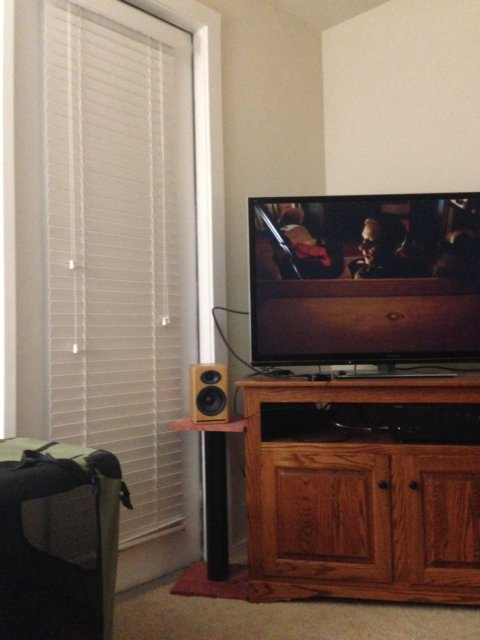

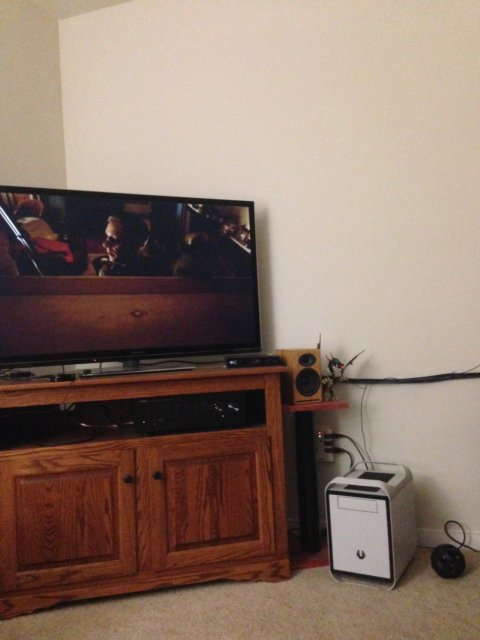

In [8]:
img1 = cv2.imread('1.jpg')
img2 = cv2.imread('2.jpg')
cv2_imshow(img1)
cv2_imshow(img2)

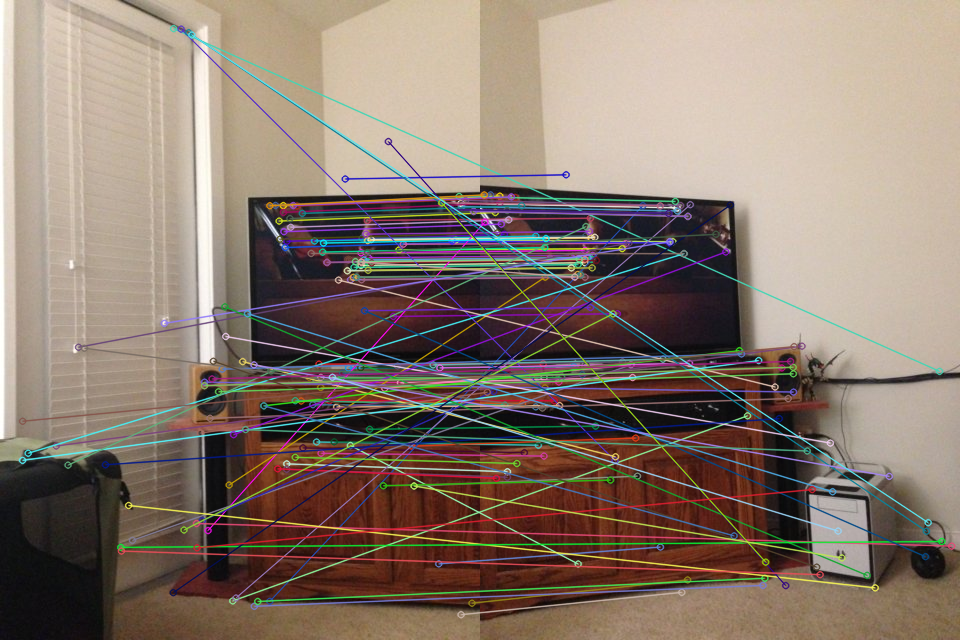

In [31]:
# Convert images to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# cv2_imshow(gray1)
# cv2_imshow(gray2)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and descriptors
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# Use BFMatcher to find matches
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des1, des2)

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)
# matches = sorted(matches, key=lambda x: x.distance)[:50]

# Draw matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
output_path = "/content/img_matches.jpg"
cv2.imwrite(output_path, img_matches)
cv2_imshow(img_matches)
cv2.waitKey(0)
cv2.destroyAllWindows()



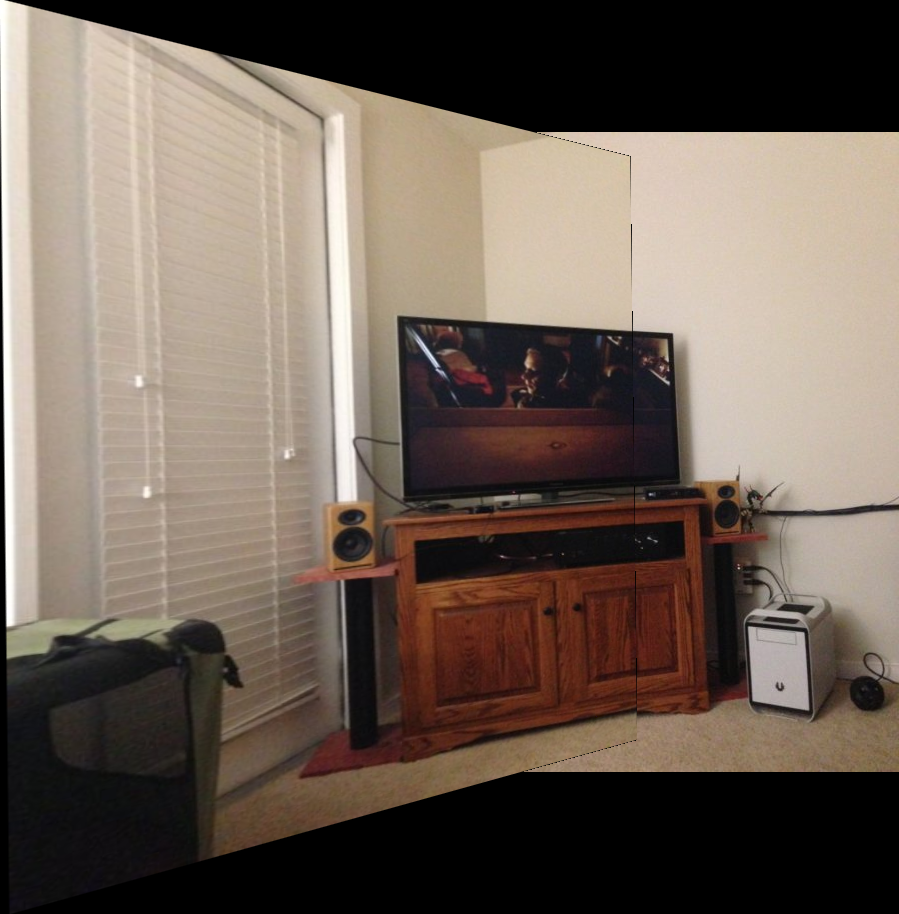

In [32]:
# Extract matched keypoints
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Compute homography
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Warp img1 to align with img2
h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]

# Get the corners of img1 in the transformed perspective
pts_img1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
pts_img1_transformed = cv2.perspectiveTransform(pts_img1, H)

# Get the bounding box dimensions for the final stitched image
pts_img2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
all_pts = np.concatenate((pts_img1_transformed, pts_img2), axis=0)

[x_min, y_min] = np.int32(all_pts.min(axis=0).ravel())
[x_max, y_max] = np.int32(all_pts.max(axis=0).ravel())

translation = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])  # Shift transformation

# Warp img1 into the panorama
img1_warped = cv2.warpPerspective(img1, translation @ H, (x_max - x_min, y_max - y_min))
img2_warped = np.zeros_like(img1_warped)
img2_warped[-y_min:h2 - y_min, -x_min:w2 - x_min] = img2  # Place img2 on the canvas

# Blend images
result = np.where(img1_warped > 0, img1_warped, img2_warped)
output_path = "/content/output.jpg"
cv2.imwrite(output_path, result)
cv2_imshow(result)
cv2.waitKey(0)
cv2.destroyAllWindows()
